<a href="https://colab.research.google.com/github/gupann/CS269-Parking/blob/anmol-parallel-parking-static-obstacles-env/parallelparking_model_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-Based Reinforcement Learning

## Parallel Parking
parking-parallel-v0

In [1]:
# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

We also define a simple helper function for visualization of episodes:

In [2]:
import sys
from tqdm import trange # from tqdm.notebook import trange
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb ffmpeg
# !git clone https://github.com/gupann/CS269-Parking.git 2> /dev/null
sys.path.insert(0, '/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts')
from utils import record_videos, show_videos

In [ ]:
# !pip install -e /content/CS269-Parking


In [3]:
# Environment
import gymnasium as gym
import highway_env

gym.register_envs(highway_env)

### Let's try it!

Make the environment, and run an episode with random actions:

Parallel Parking

In [16]:
env = gym.make("parking-parallel-v0", render_mode="rgb_array")
env = record_videos(env)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/highway-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/aayush_wsl/cs269_rl_parking/CS269-Parking/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Studying the environment, action space, reward  
1.) How and what modifications can be made to the environment  
2.) Figuring out how the action space looks like  
3.) How can I change the reward definition  
4.) How is collision detected in the environment  
5.) How is goal position specified in the environment  

In [ ]:
print(env.unwrapped.config[])

{'observation': {'type': 'KinematicsGoal', 'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'], 'scales': [100, 100, 5, 5, 1, 1], 'normalize': False}, 'action': {'type': 'ContinuousAction'}, 'simulation_frequency': 15, 'policy_frequency': 5, 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle', 'screen_width': 600, 'screen_height': 300, 'centering_position': [0.5, 0.5], 'scaling': 7, 'show_trajectories': False, 'render_agent': True, 'offscreen_rendering': False, 'manual_control': False, 'real_time_rendering': False, 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02], 'success_goal_reward': 0.12, 'collision_reward': -5, 'steering_range': np.float64(0.7853981633974483), 'duration': 100, 'controlled_vehicles': 1, 'vehicles_count': 0, 'add_walls': True, 'street_length': 60.0, 'curb_offset': 10.0, 'n_slots': 8, 'empty_slot_index': 3, 'wall_margin': 4.0}


The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [5]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([ 0.37543386, -0.07072217,  0.25059569, -0.11115646,  0.91410833,
       -0.40547005])), ('achieved_goal', array([ 0.37543386, -0.07072217,  0.25059569, -0.11115646,  0.91410833,
       -0.40547005])), ('desired_goal', array([ 0.26875, -0.1    ,  0.     ,  0.     ,  1.     ,  0.     ]))])


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [6]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            if done:
              previous_obs, info = env.reset()
            obs, reward, done, truncated, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
            previous_obs = obs
    return data

env = gym.make("parking-parallel-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([0.1200, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000]), action=tensor([-0.0492, -0.5311]), next_state=tensor([ 1.1997e-01,  7.0862e-06, -9.8301e-03, -2.7871e-06,  1.0000e+00,
         2.8353e-04]))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems*

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation comes from the Control Theory community and stands for the state and action $(s,a)$. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [7]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:",
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.1668, -0.0674,  0.0330, -0.0320,  1.0433, -0.0025]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

Train dynamics: 100%|██████████| 1500/1500 [00:04<00:00, 357.16it/s]


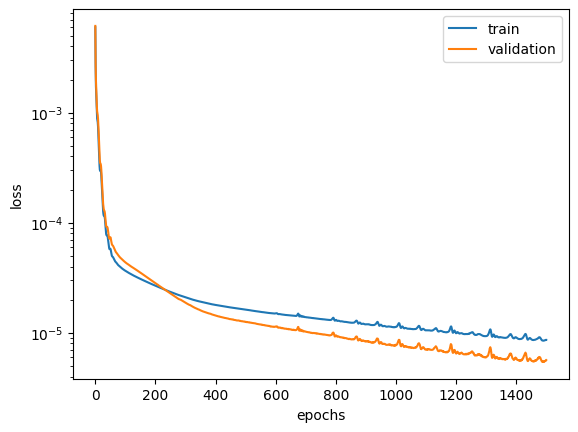

In [8]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


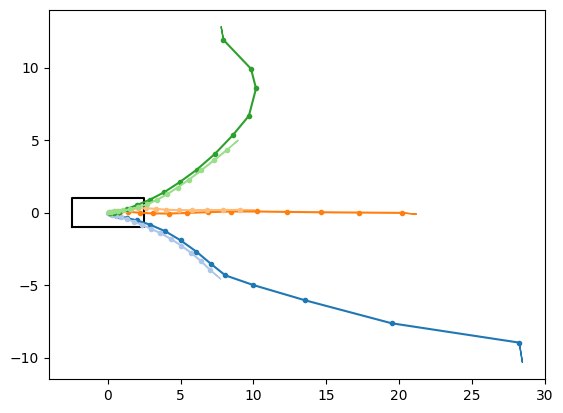

In [9]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()

visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [10]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.4228])


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [11]:
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = torch.normal(mean=action_mean.repeat(1, population, 1), std=action_std.repeat(1, population, 1))
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean = best_actions.mean(dim=1, keepdim=True)
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)


# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
print("Planned action:", action)

Planned action: tensor([-0.7419,  0.0947])


## Visualize a few episodes

En voiture, Simone !

In [12]:
env = gym.make("parking-parallel-v0", render_mode='rgb_array')
env = record_videos(env)
obs, info = env.reset()

for step in trange(3 * env.unwrapped.config["duration"], desc="Testing 3 episodes..."):
    action = cem_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0])
    obs, reward, done, truncated, info = env.step(action.numpy())
    if done or truncated:
        obs, info = env.reset()
env.close()
show_videos()

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/highway-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/aayush_wsl/cs269_rl_parking/CS269-Parking/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Testing 3 episodes...: 100%|██████████| 300/300 [00:26<00:00, 11.47it/s]
